In [1]:
from hrgeos import HrgEosIntegration
import mplhep as hp
hp.style.use("ALICE")

# 拿两个粒子和课件上的做对比，检验代码是否有bug

In [2]:
proton_calculator = HrgEosIntegration("p")
pi0_calculator = HrgEosIntegration("pi0")

In [3]:
print("proton_mass", proton_calculator.particle.mass)
print("pi0_mass", pi0_calculator.particle.mass)

proton_mass 0.93827208816
pi0_mass 0.134976827767685


In [4]:
temper = 0.155
pi0_density = pi0_calculator.density_n(temper)
proton_density = proton_calculator.density_n(temper)

print("ratio pion / proton=", pi0_density / proton_density)

ratio pion / proton= 16.10203201310647


# 测试代码，定义一个质量为0的强子
###### 由于PDG API不可能有这种东西，所以继承之前的类然后重载构造函数
# 显然有如下公式
$$
P = \frac{\epsilon}{3}
$$

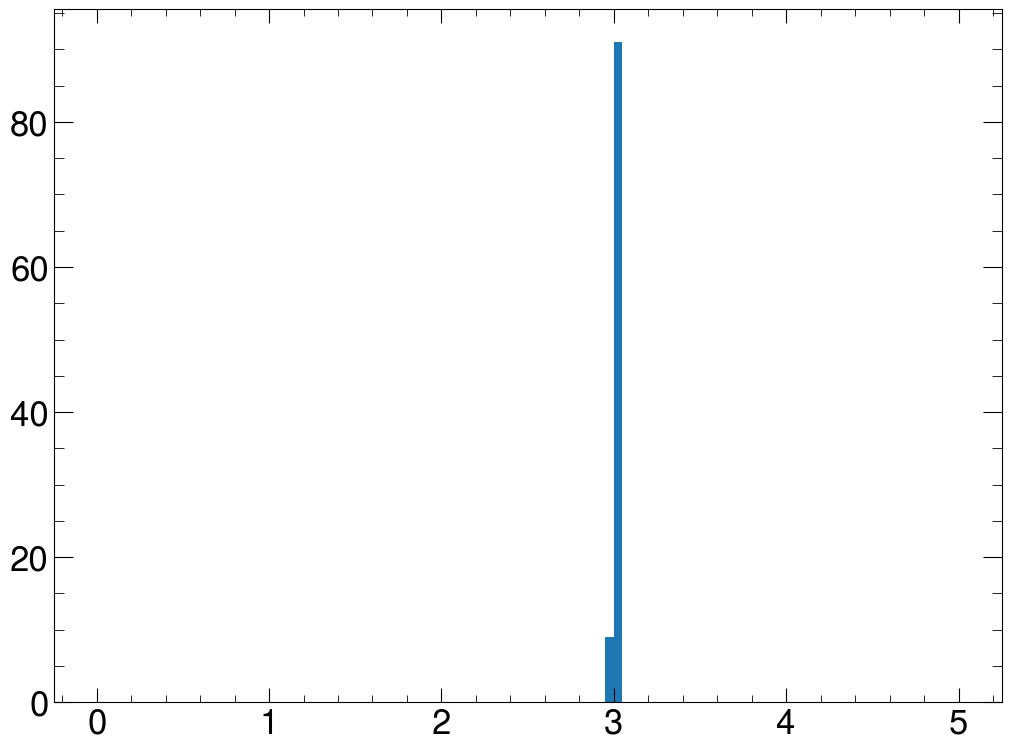

In [5]:
import numpy as np
class ZeroMass(HrgEosIntegration):
    def __init__(self):
        class Particle:
            def __init__(self):
                self.quantum_J = "0"
                self.is_boson = True
                self.mass = 0.0
        self.particle = Particle()
        
Tarr = np.linspace(0.01, 0.2, 100)

particle_zero_mass = ZeroMass()

ed = [particle_zero_mass.energy_density_e(i) for i in Tarr]

pr = [particle_zero_mass.pressure_p(i) for i in Tarr]

import matplotlib.pyplot as plt

_ = plt.hist(np.array(ed) / np.array(pr), range=(0, 5), bins=100)

\begin{align}
    c_s^2 &= \frac{dp}{d\epsilon}
\end{align}
# 先用质子画一个简单的图
# 检查代码是否有问题

In [6]:
def get_c_s_square(pressure_arr, energy_arr):
    return np.gradient(pressure_arr, energy_arr)

In [7]:
from tqdm import tqdm
def get_pressure_from_class(calc, Tarr):
    res = []
    for i in tqdm(Tarr):
        res.append(calc.pressure_p(i))
        
    return res

def get_energy_from_class(calc, Tarr):
    res = []
    for i in tqdm(Tarr):
        res.append(calc.energy_density_e(i))
        
    return res
        

In [8]:
T = np.linspace(0.01, 0.2, 10)
proton_cs_square = get_c_s_square(get_pressure_from_class(proton_calculator, T), get_energy_from_class(proton_calculator, T))

100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


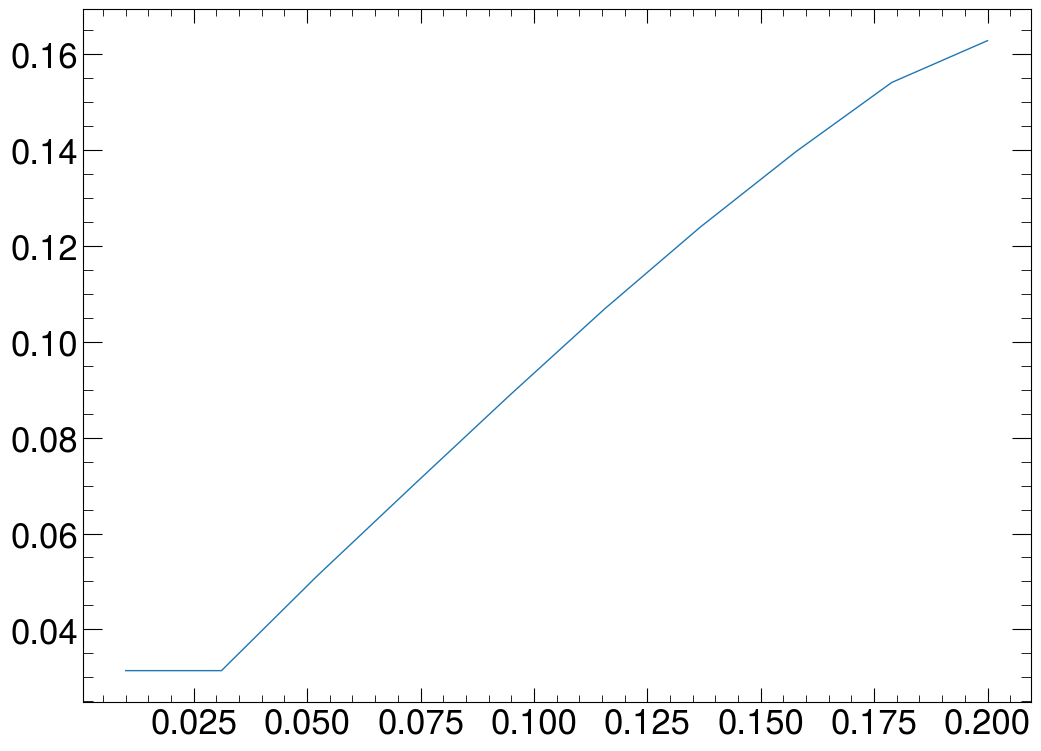

In [9]:
import matplotlib.pyplot as plt
plt.plot(T, proton_cs_square)

# 对表中所有的粒子计算，并求和
### 这个表的PDG ID可能存在问题，用api去查，有的粒子会报错
###### 所以为了不动前面写好的一大批代码，得把构造函数再override一遍

In [10]:
import pandas as pd
df = pd.read_csv(r"D:\chongzhuang\huinaibingLinux\python_code\deeplearning\DATA_FILES\hadron_table.csv")
df

,Unnamed: 0,pdg,name,mass,decay_width,2*spin+1,isbaryon,strange_num,charge_num,eta
0,0,211,Pion(+),0.13957,0.000,1,0,0,1,-1.0
1,1,111,Pion(0),0.13498,0.000,1,0,0,0,-1.0
2,2,-211,Pion(-),0.13957,0.000,1,0,0,-1,-1.0
3,3,321,Kaon(+),0.49368,0.000,1,0,1,1,-1.0
4,4,-321,Kaon(-),0.49368,0.000,1,0,-1,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...
314,314,-12226,antiDelta1930(++),1.96000,0.360,6,1,0,-2,1.0
315,315,-12126,antiDelta1930(+),1.96000,0.360,6,1,0,-1,1.0
316,316,-11216,antiDelta1930(0),1.96000,0.360,6,1,0,0,1.0
317,317,-11116,antiDelta1930(-),1.96000,0.360,6,1,0,1,1.0


In [11]:
class Particle:
    def __init__(self, mass, spin2_plus_1, eta):
        self.mass = mass
        self.quantum_J = str((spin2_plus_1 - 1) / 2.0)
        self.is_boson = True if eta == -1 else False


In [12]:
class HrgDataFromCSV(HrgEosIntegration):
    def __init__(self, particle_class):
        self.particle = particle_class

In [13]:
all_particles = []

for _, row in df.iterrows():
    particle = Particle(
        mass=row['mass'],
        spin2_plus_1=row['2*spin+1'], 
        eta=row['eta']
    )
    all_particles.append(HrgDataFromCSV(particle))


In [14]:
for i in all_particles[:10]:
    print(i.particle.mass)

0.13957
0.13498
0.13957
0.49368
0.49368
0.49765
0.49765
0.54775
0.7758
0.7758


# 使用多进程

In [15]:
from pathos.multiprocessing import ProcessingPool

all_particle_pressures = []
all_particle_energies = []

In [16]:

def get_pressure_from_class(calc):
    import numpy as np
    Tarr = np.linspace(0.1, 0.2, 100)
    res = []
    for i in Tarr:
        res.append(calc.pressure_p(i))
        
    return res

def get_energy_from_class(calc):
    import numpy as np
    Tarr = np.linspace(0.1, 0.2, 100)
    res = []
    for i in Tarr:
        res.append(calc.energy_density_e(i))
        
    return res


In [17]:
pool = ProcessingPool(8)
all_particle_pressures = pool.map(get_pressure_from_class, all_particles)
all_particle_energies = pool.map(get_energy_from_class, all_particles)

经过尝试，从PDG的API获取数据，每一次获取都是向云端数据库获取数据，导致前面的代码运行十分缓慢
###### 所以这里多进程完全没必要

In [18]:
pressures_sum = np.sum(all_particle_pressures, axis=0)
energy_sum = np.sum(all_particle_energies, axis=0)

In [19]:
res = np.gradient(pressures_sum, energy_sum)

# paper 的数据使用automeris直接扣下来

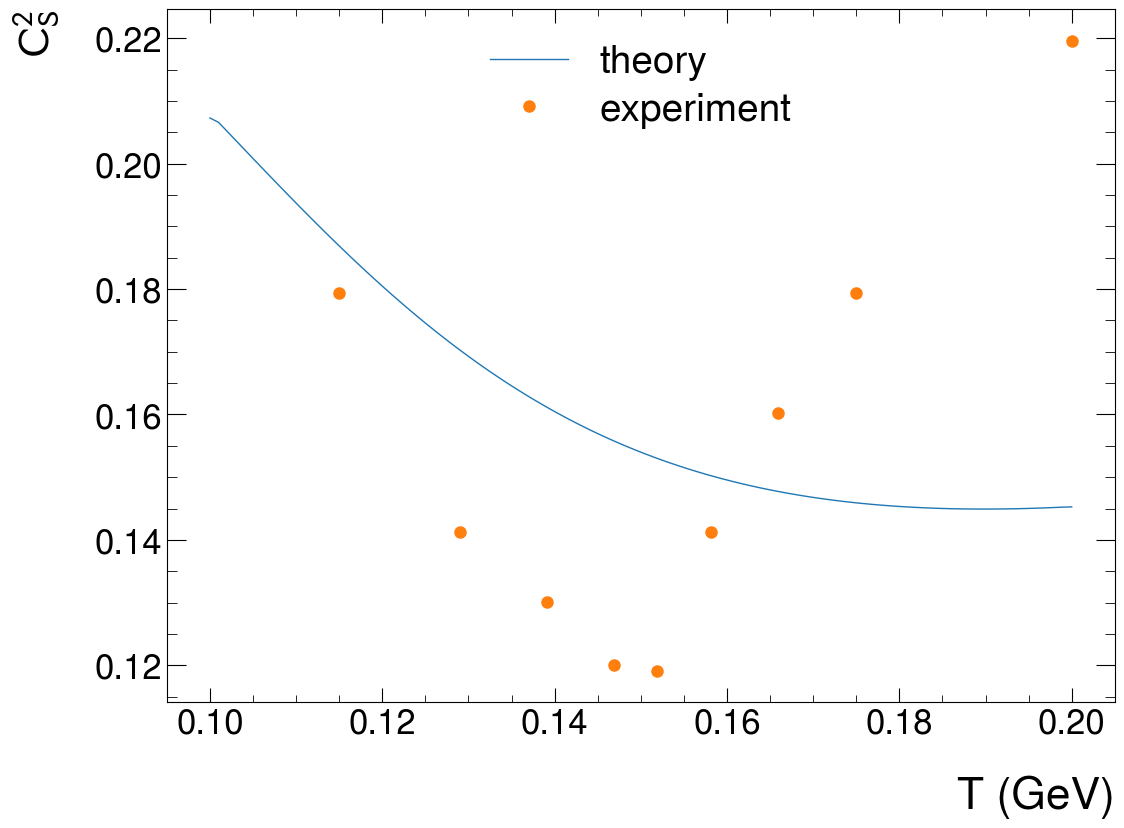

In [20]:
plt.plot(np.linspace(0.1, 0.2, 100), res, label="theory")
df_paper = pd.read_csv(r"D:\chongzhuang\huinaibingLinux\python_code\deeplearning\DATA_FILES\papers_data.csv")
plt.plot(df_paper.iloc[:, 0] / 1000, df_paper.iloc[:, 1], 'o', label="experiment")
plt.xlabel("T (GeV)")
plt.ylabel("$C_S^2$")
plt.legend(loc="upper center")